In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os

from brian2 import *
from brian2tools import *

import matplotlib.pyplot as plt
import scipy

import cx_rate
import trials
import plotter
import bee_simulator

In [15]:
from cx_spiking.central_complex import CX_SPIKING
from cx_spiking.constants import *
import cx_spiking 

In [16]:
######################################
### INPUTS
######################################
route_file = os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/data/route.npz')
T_outbound = 1500
T_inbound = 1500
T = T_outbound+T_inbound

h, v, = cx_spiking.inputs.generate_route(T_outbound=1500, vary_speed=True, route_file=route_file, load_route=True)

cx_spiking.inputs.save_route(route_file, h, v, save_route=False)

# Convert headings
headings = cx_spiking.inputs.compute_headings(h, N=N_TL2//2, vmin=5, vmax=100)
headings = np.tile(headings, 2)
headings = np.concatenate((headings, np.zeros((T_inbound, headings.shape[1]))), axis=0)

# Convert velocity into optical flow
flow = cx_spiking.inputs.compute_flow(h, v, baseline=50, vmin=0, vmax=50)
flow = np.concatenate((flow, np.zeros((T_inbound, flow.shape[1]))), axis=0)

Load route from /Users/ff/dev/MSc/CX_Path_Integration/notebooks/data/route.npz


In [17]:
######################################
### RATE BASED CX
######################################
noise = 0.1
cx = cx_rate.CXRatePontin(noise=noise)

h, v, cx_log, cpu4_snapshot = trials.run_trial(logging=True,
                                               T_outbound=T_outbound,
                                               T_inbound=T_inbound,
                                               noise=noise,
                                               cx=cx,
                                               route=(h[:T_outbound], v[:T_outbound]))

In [18]:
######################################
### SPIKING CX
######################################
cpu4_method = 1

mem_gain_outbound = 0.05
decay_outbound= 0.025
mem_gain_inbound = 0.05
decay_inbound = 0.033

rotation_factor = 0.1

spiking_cx = CX_SPIKING(eqs, threshold_eqs, reset_eqs,
                headings, flow, cpu4_method, 
                mem_gain_outbound, decay_outbound, mem_gain_inbound, decay_inbound,
                rotation_factor, time_step=20, T_outbound=T_outbound,
                T_inbound=T_inbound)

In [19]:
spiking_cx.run_outbound()
spiking_cx.plot_bee_position()

Run network outbound for 1500 steps
Starting simulation at t=0. s for a duration of 30. s
2.0974 s (6%) simulated in 10s, estimated 2m 13s remaining.
4.2846 s (14%) simulated in 20s, estimated 2m 0s remaining.
6.5595 s (21%) simulated in 30s, estimated 1m 47s remaining.
8.7137 s (29%) simulated in 40s, estimated 1m 38s remaining.
10.9973 s (36%) simulated in 50s, estimated 1m 26s remaining.
13.2662 s (44%) simulated in 1m 0s, estimated 1m 16s remaining.
15.5599 s (51%) simulated in 1m 10s, estimated 1m 5s remaining.
17.8332 s (59%) simulated in 1m 20s, estimated 55s remaining.
20.1334 s (67%) simulated in 1m 30s, estimated 44s remaining.
22.4302 s (74%) simulated in 1m 40s, estimated 34s remaining.
24.7007 s (82%) simulated in 1m 50s, estimated 24s remaining.
26.975 s (89%) simulated in 2m 0s, estimated 13s remaining.
29.2759 s (97%) simulated in 2m 10s, estimated 3s remaining.
30. s (100%) simulated in 2m 13s


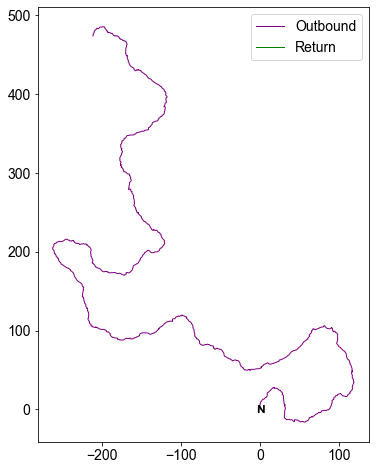

Run network for 1500 steps
Starting simulation at t=30. s for a duration of 30. s
1.9216 s (6%) simulated in 10s, estimated 2m 26s remaining.
3.6995 s (12%) simulated in 20s, estimated 2m 22s remaining.
5.8003 s (19%) simulated in 30s, estimated 2m 5s remaining.
7.7037 s (25%) simulated in 40s, estimated 1m 56s remaining.
9.6313 s (32%) simulated in 50s, estimated 1m 46s remaining.
11.9271 s (39%) simulated in 1m 0s, estimated 1m 31s remaining.
13.9235 s (46%) simulated in 1m 10s, estimated 1m 21s remaining.
15.7688 s (52%) simulated in 1m 20s, estimated 1m 12s remaining.
17.8936 s (59%) simulated in 1m 30s, estimated 1m 1s remaining.
20.1085 s (67%) simulated in 1m 40s, estimated 49s remaining.
22.0969 s (73%) simulated in 1m 50s, estimated 39s remaining.
24.1385 s (80%) simulated in 2m 0s, estimated 29s remaining.
25.9796 s (86%) simulated in 2m 10s, estimated 20s remaining.
28.0167 s (93%) simulated in 2m 20s, estimated 10s remaining.
29.983 s (99%) simulated in 2m 30s, estimated < 

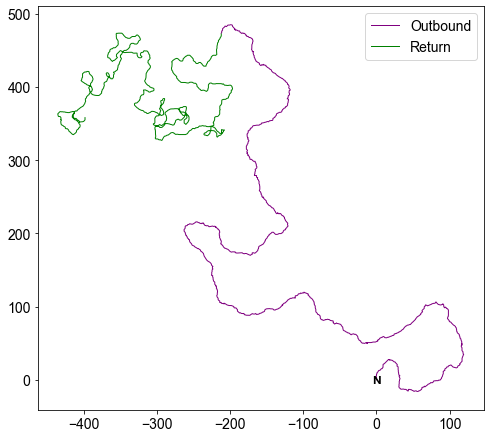

In [9]:
spiking_cx.run_inbound()
spiking_cx.plot_bee_position()

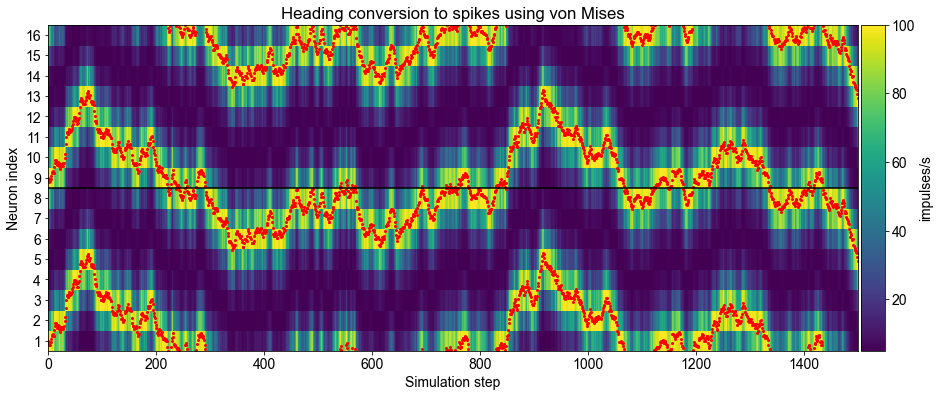

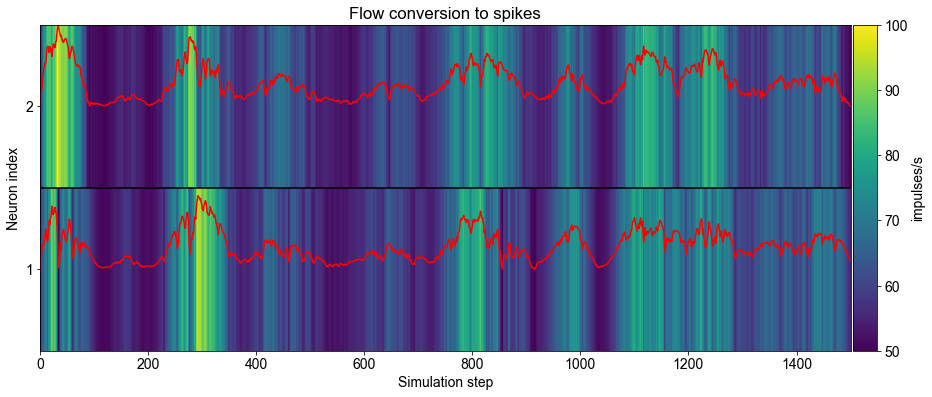

In [22]:
cx_spiking.plotting.plot_inputs(spiking_cx, h, v)

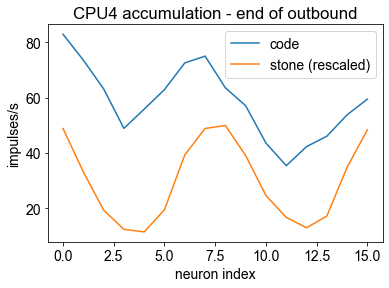

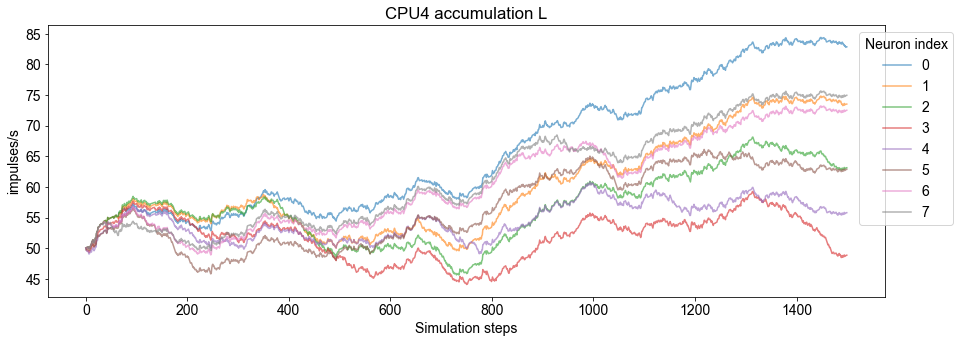

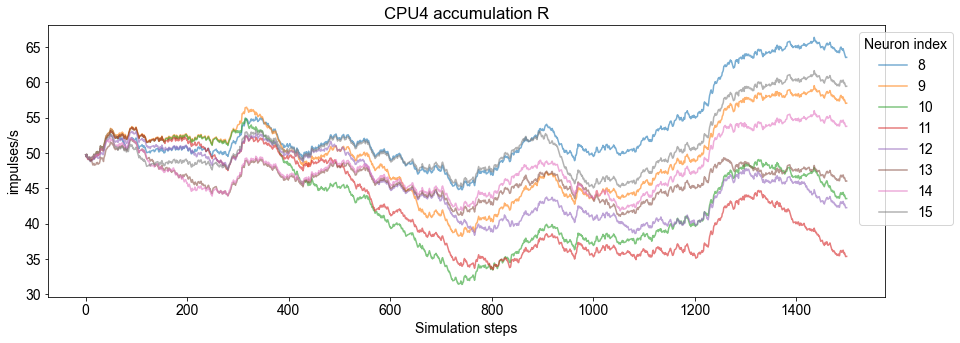

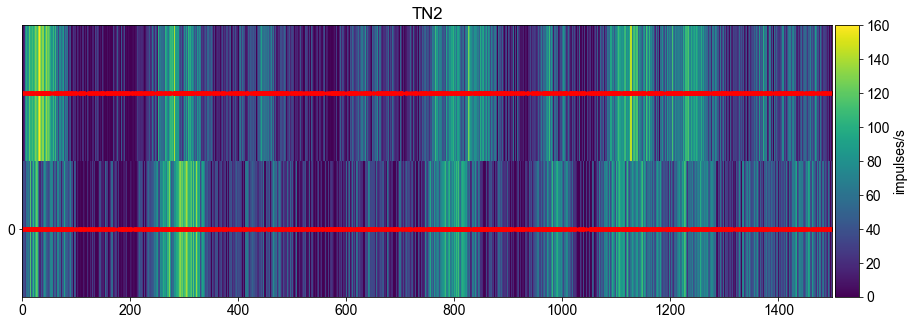

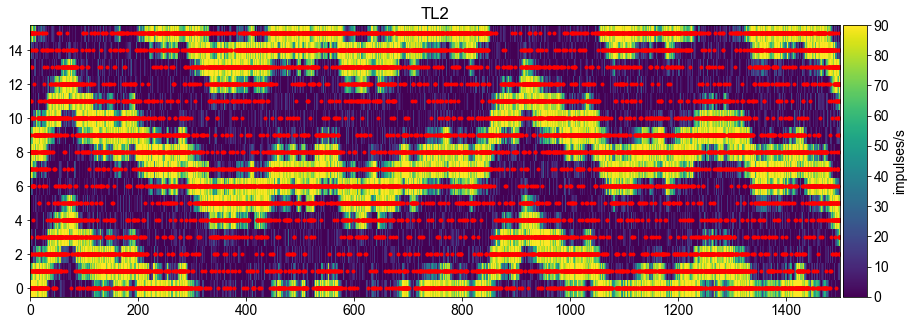

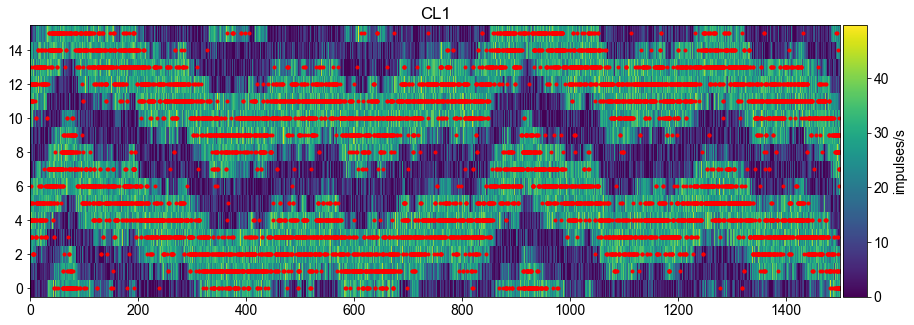

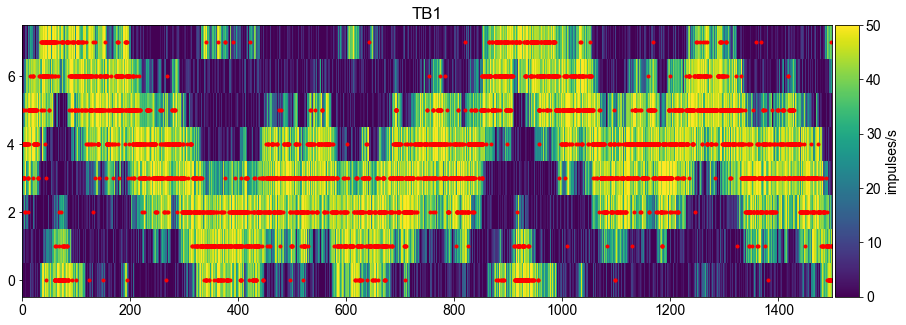

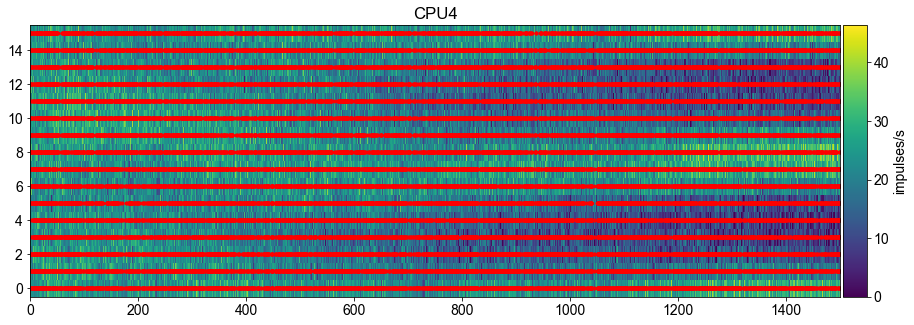

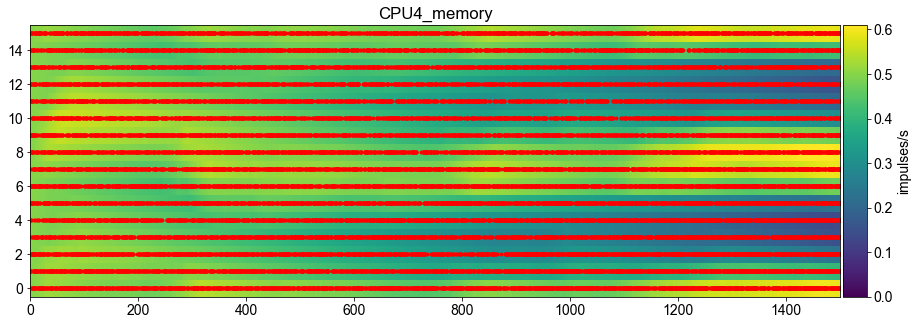

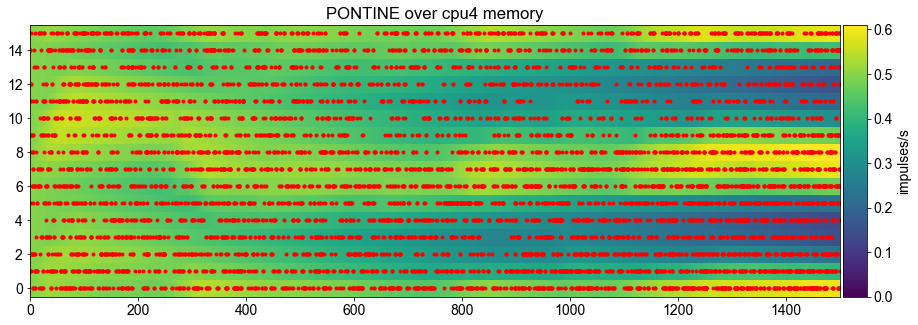

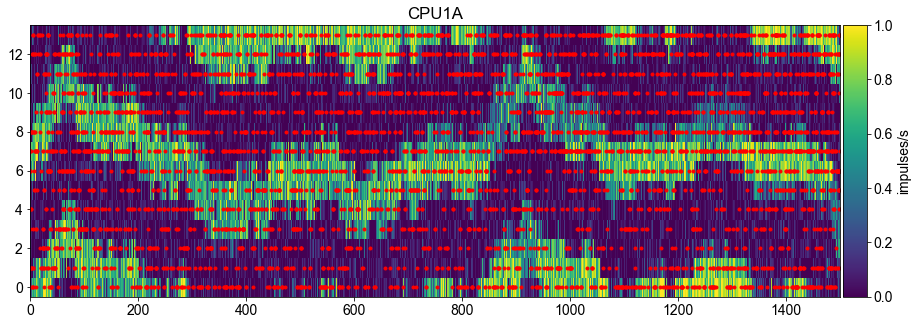

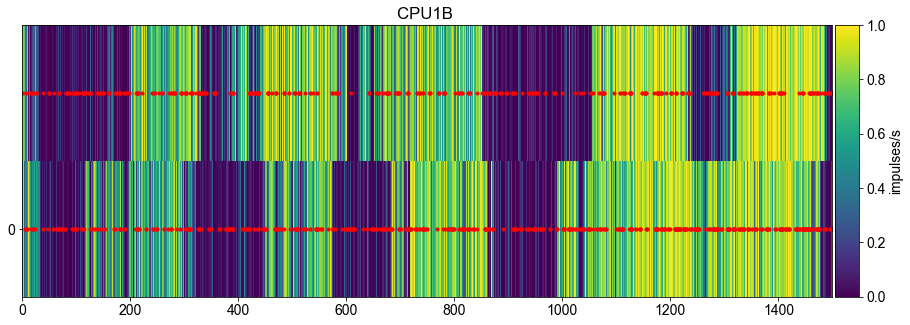

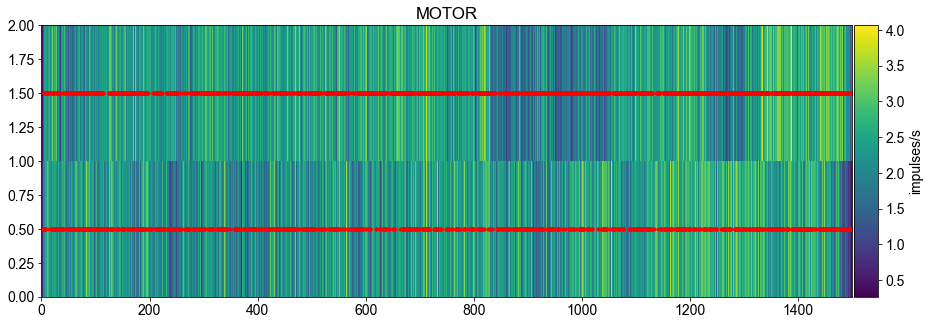

In [23]:
cx_spiking.plotting.plot_memory_outbound(spiking_cx, cx_log)
cx_spiking.plotting.plot_populations_outbound(spiking_cx, cx_log)

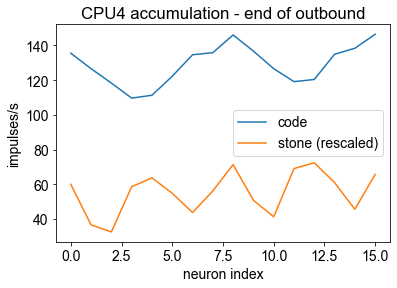

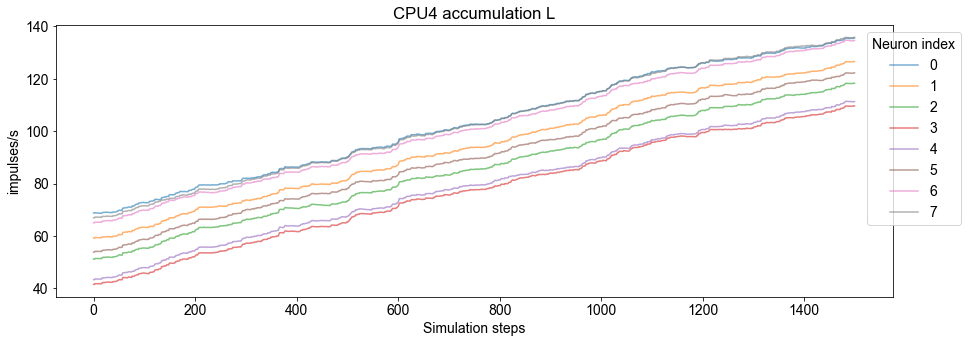

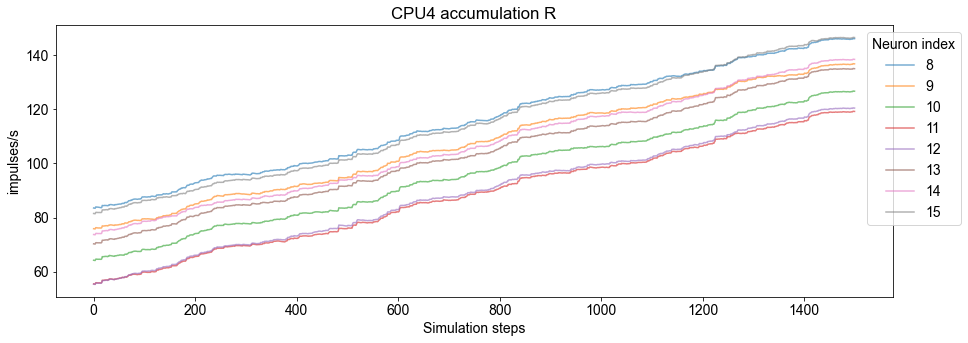

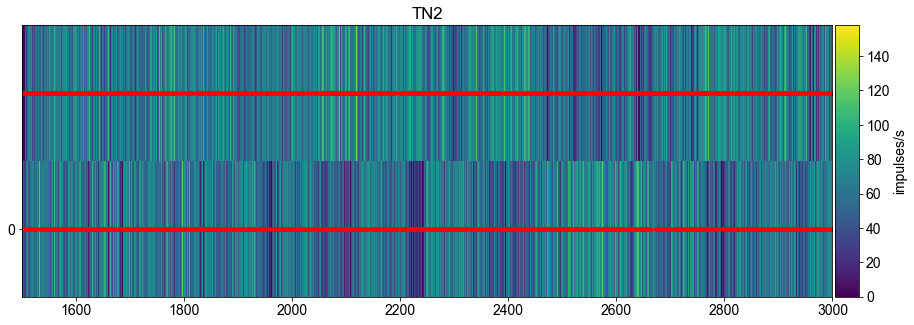

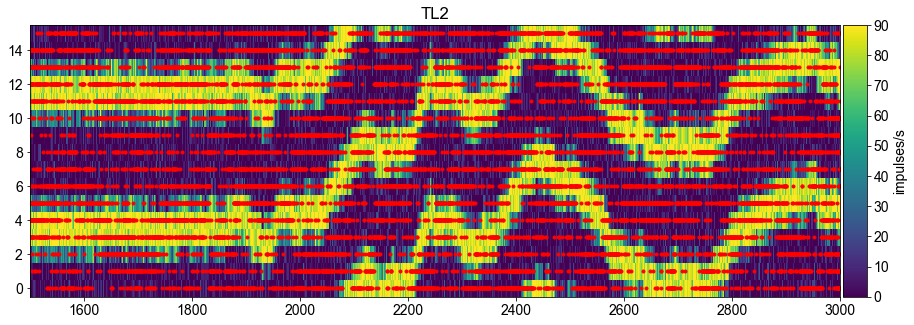

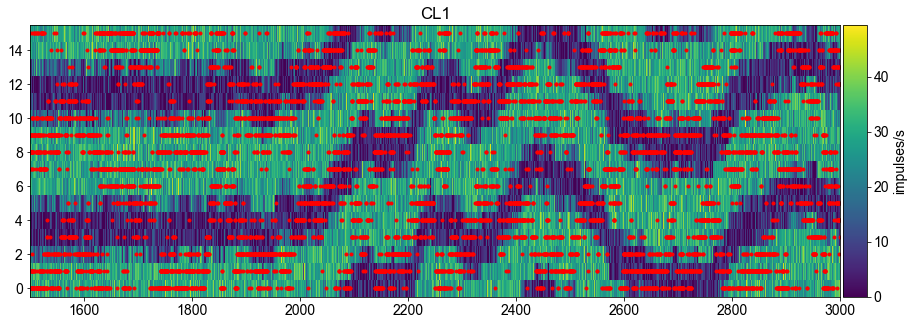

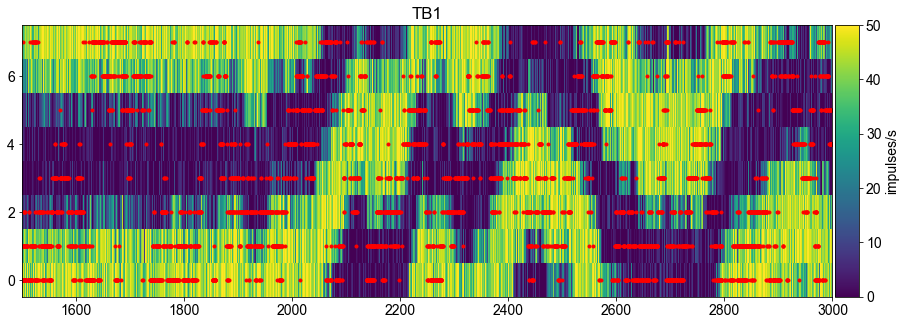

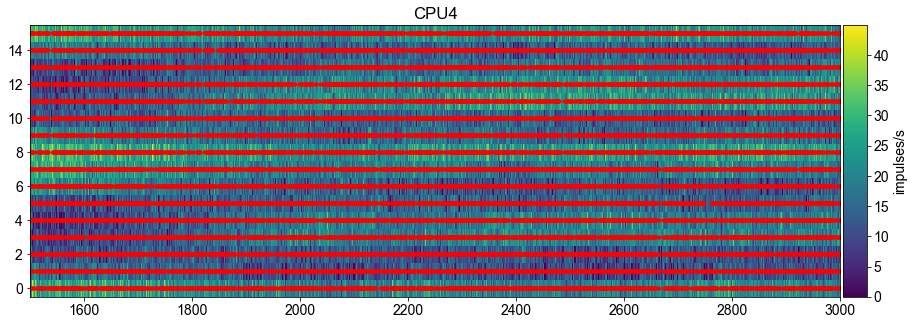

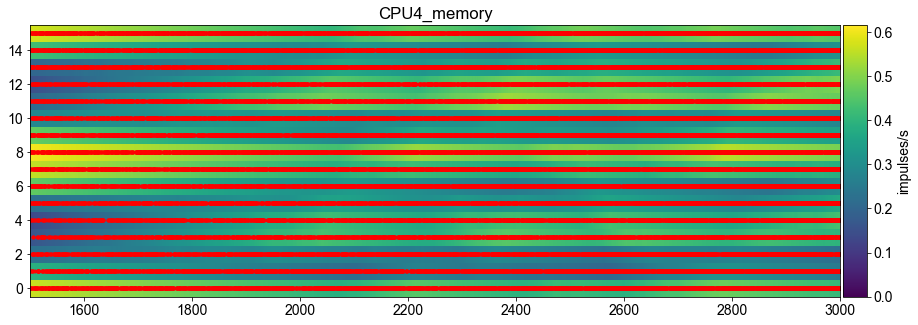

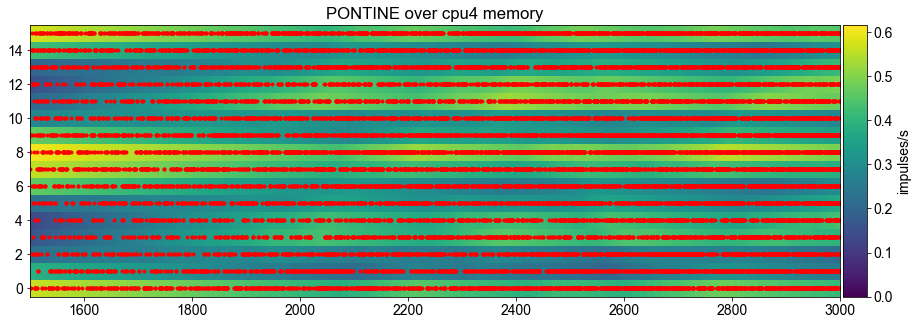

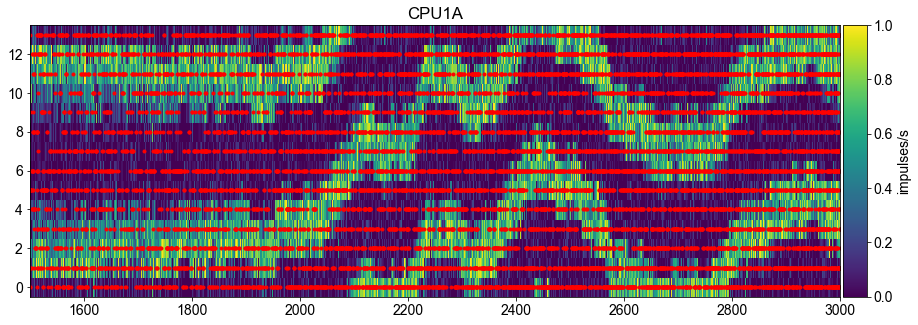

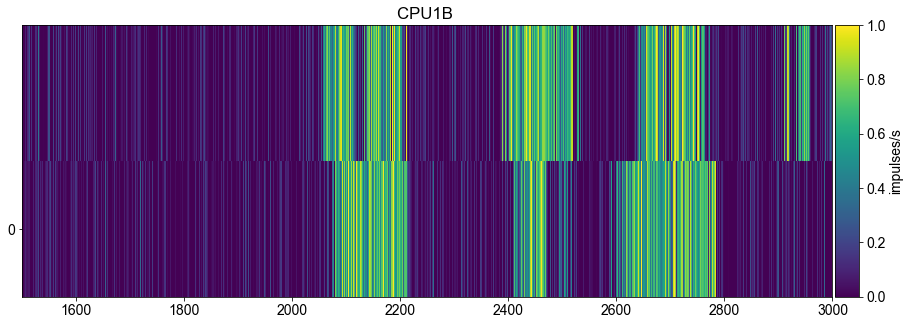

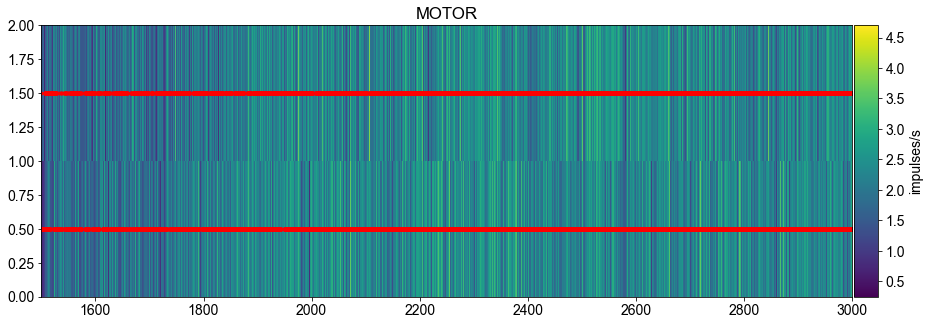

In [14]:
cx_spiking.plotting.plot_memory_inbound(spiking_cx, cx_log)
cx_spiking.plotting.plot_populations_inbound(spiking_cx, cx_log)